In [80]:
import random
import numpy as np

import initialization
import evaluation
import parent_selection
import crossover
import survivor_selection
import environment
import mutation

import seaborn as sb
import pandas as pd
import matplotlib.pyplot as plt

In [81]:
class BinsEA:

    def __init__(self, training=None, bin_info=environment.BinInfo('../datasets/BinLocations.csv', '../datasets/BinDistances.csv'), pop_size=24, mating_pool_size=8, tournament_size=4, crossover_rate=0, mut_rate=0.3, max_gen=1000, target=25, rng=True):
        self.bin_info=bin_info
        self.training=training
        self.pop_size=pop_size
        self.mating_pool_size=mating_pool_size
        self.tournament_size=tournament_size
        self.crossover_rate=crossover_rate
        self.mut_rate=mut_rate
        self.max_gen=max_gen
        self.target=target
        if(rng == False):
            random.seed()

    def main(self, crossover_type=0):

        bin_count = len(self.bin_info.bins)
        avg_dist = []

        # Initialization
        population = initialization.pop_init(self.pop_size, self.bin_info, bin_count)
        fitness = [] # Fitness ranges from 0 to bin_count
        for i in population:
            fitness.append(evaluation.fitness(i, self.bin_info))
        gen = 0
        og_fitness = fitness.copy()
        # Main Evolutionary Loop
        while (gen < self.max_gen and max(fitness) < self.target):

            parents = parent_selection.tournament_select(population, fitness, self.mating_pool_size, self.tournament_size)
            random.shuffle(parents)
            offspring = []
            offspring_fitness = []
            
            i=0
            while len(offspring) < self.mating_pool_size - 1:
                if crossover_type == 0 :
                    # Generates 2 new offspring using PMX
                    off = crossover.crossover_main(population[parents[i]], population[parents[i+1]], self.crossover_rate, 0)
                    # Performs inversion mutation on offspring
                    off1 = mutation.inv_mut(off[0],self.mut_rate)
                    off2 = mutation.inv_mut(off[1],self.mut_rate)
                    offspring.append(off1)
                    offspring.append(off2)
                    offspring_fitness.append(evaluation.fitness(off1,self.bin_info))
                    offspring_fitness.append(evaluation.fitness(off2,self.bin_info))
                    i += 2
                else: 
                    off = crossover.crossover_main(population[parents[i]], population[parents[i+1]], self.crossover_rate, 1)
                    off = mutation.inv_mut(off,self.mut_rate)
                    offspring.append(off)
                    offspring_fitness.append(evaluation.fitness(off,self.bin_info))
                    i += 1

            population, fitness = survivor_selection.mu_plus_lambda(population, fitness, offspring, offspring_fitness)
            print("gen: ",gen," - max fit: ",max(fitness)," - pop size: ", len(population))
            avg_dist.append(len(population[0]) / (sum(fitness)/len(fitness)))

            """ The following was used in order to test and create visual representations
            of how the best route of each generation improved over time:

            if(gen % 100 == 0):
                latitudes = []
                longitudes = []
                route = population[fitness.index(max(fitness))]
                for bin in route:
                    lat, lon = self.bin_info.get_coord(bin)
                    latitudes.append(lat)
                    longitudes.append(lon)
                    
                latitudes.append(latitudes[0])
                longitudes.append(longitudes[0])

                plt_route, ax = plt.subplots()
                ax.plot(longitudes, latitudes, '-go', linewidth=1, color='black')        
                plt.title(label=("Best Route Found After " +  str(gen) +  " Generations | Length = " + str(round(len(route)/max(fitness),2)) + " km"))

                plt_route.set_size_inches(12, 10)    
                plt.savefig('solution' + str(gen) + '.png')
            """

            gen += 1

        return population, fitness, og_fitness, gen, avg_dist

In [82]:
bin_info = environment.BinInfo('../datasets/BinLocations_Medium.csv', '../datasets/BinDistances_Medium.csv')
pop_size = 120
mating_pool_size = 80 # Must be even
tournament_size = 20
crossover_rate = 0.5
mut_rate = 0.7
max_gen = 5000
# Small: 5.8 | Medium: 11.78 | Large: ??
target_fitness = 15

gen_count = 0
model = BinsEA(bin_info.bins, bin_info, pop_size, mating_pool_size, tournament_size, crossover_rate, mut_rate, max_gen, target_fitness, True)
population, fitness, fitness_o, gen_count, avg_dist = model.main(1)
route = population[fitness.index(max(fitness))]

gen:  0  - max fit:  1.3742811853478678  - pop size:  120
gen:  1  - max fit:  1.3742811853478678  - pop size:  120
gen:  2  - max fit:  1.3742811853478678  - pop size:  120
gen:  3  - max fit:  1.3742811853478678  - pop size:  120
gen:  4  - max fit:  1.3861122570527786  - pop size:  120
gen:  5  - max fit:  1.5456547612362512  - pop size:  120
gen:  6  - max fit:  1.5458034760067687  - pop size:  120
gen:  7  - max fit:  1.5484808969323025  - pop size:  120
gen:  8  - max fit:  1.5484808969323025  - pop size:  120
gen:  9  - max fit:  1.6331319753751377  - pop size:  120
gen:  10  - max fit:  1.6331319753751377  - pop size:  120
gen:  11  - max fit:  1.6331319753751377  - pop size:  120
gen:  12  - max fit:  1.6809850879609398  - pop size:  120
gen:  13  - max fit:  1.6809850879609398  - pop size:  120
gen:  14  - max fit:  1.6809850879609398  - pop size:  120
gen:  15  - max fit:  1.7034535952873118  - pop size:  120
gen:  16  - max fit:  1.7118203411721815  - pop size:  120
gen:  1

#### Evolutionary Algorithm Summary

Best Individual: [98, 97, 91, 93, 96, 92, 94, 90, 28, 82, 57, 36, 49, 6, 77, 80, 11, 51, 68, 8, 65, 81, 38, 46, 14, 23, 62, 21, 72, 66, 74, 83, 12, 70, 26, 1, 88, 33, 3, 54, 35, 78, 13, 76, 63, 5, 48, 0, 10, 47, 40, 34, 42, 86, 20, 58, 89, 53, 37, 61, 39, 16, 84, 56, 64, 30, 15, 59, 29, 75, 22, 87, 71, 67, 41, 4, 69, 9, 85, 24, 44, 52, 31, 55, 2, 73, 45, 27, 7, 79, 50, 25, 43, 18, 32, 60, 17, 19, 95, 99]
Best Fitness: 12.0951414050139     Target Fitness: 15
Best Route Length: 8.27 KM

Average Improvement Per Generation: 0.19 % Fitness Increase
Generations to Terminate: 5000
Max Generations Allowed 5000 

'Bad' Paths: 0


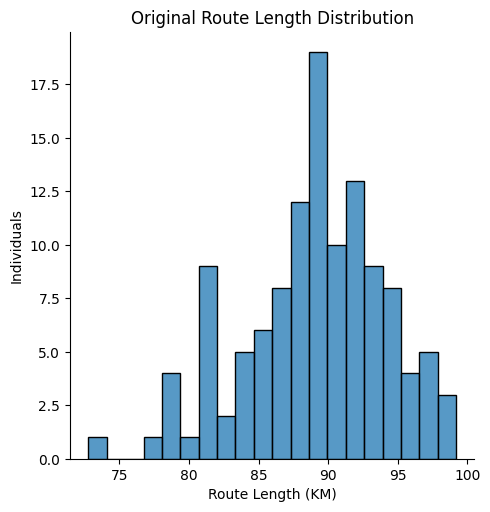

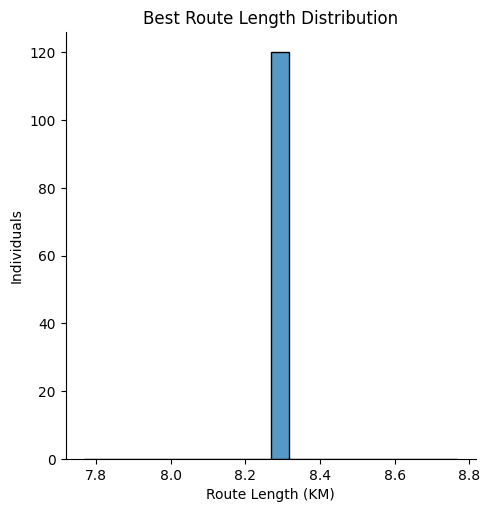

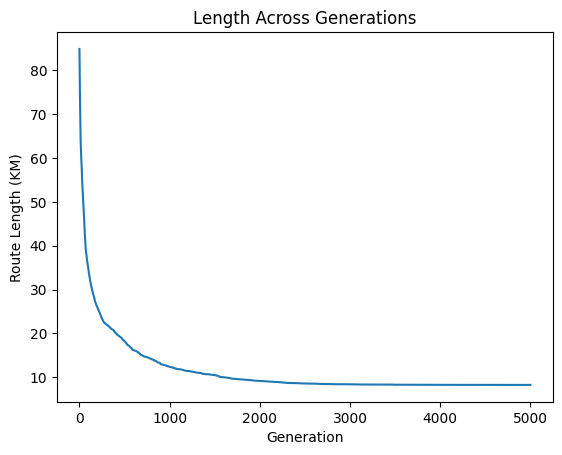

In [83]:
print("Best Individual:", route)
print("Best Fitness:", evaluation.fitness(route, bin_info), "    Target Fitness:", target_fitness)
print("Best Route Length:", round(len(route)/evaluation.fitness(route, bin_info),2),"KM\n")

try:
    fitness_increase = ((sum(fitness) - sum(fitness_o)) / sum(fitness_o))/gen_count
except ZeroDivisionError:
    fitness_increase = 0.0
print("Average Improvement Per Generation:",round(fitness_increase*100,2),"% Fitness Increase")
print("Generations to Terminate:", gen_count)
print("Max Generations Allowed", max_gen, "\n")

count = 0
for i in range(len(route)-1):
    if(bin_info.get_dist(route[i], route[i+1]) == 1):
        count += 1
print("\'Bad\' Paths:", count)

len_map = pd.DataFrame({"Route Length": [len(route)/f for f in fitness]})
len_map_o = pd.DataFrame({"Route Length": [len(route)/f for f in fitness_o]})
dist_map = pd.DataFrame({"length": avg_dist})

plt1=sb.displot(len_map_o,x="Route Length",bins=20).set(title="Original Route Length Distribution", xlabel='Route Length (KM)', ylabel="Individuals")
plt.show()
plt2=sb.displot(len_map,x="Route Length",bins=20).set(title="Best Route Length Distribution", xlabel='Route Length (KM)', ylabel="Individuals")
plt.show()
if(gen_count > 0):
    plt3=sb.lineplot(x=dist_map.index, y='length', data=dist_map).set(title="Length Across Generations", xlabel='Generation', ylabel="Route Length (KM)")
    plt.show()

### Route Visualization

color is redundantly defined by the 'color' keyword argument and the fmt string "-go" (-> color='g'). The keyword argument will take precedence.


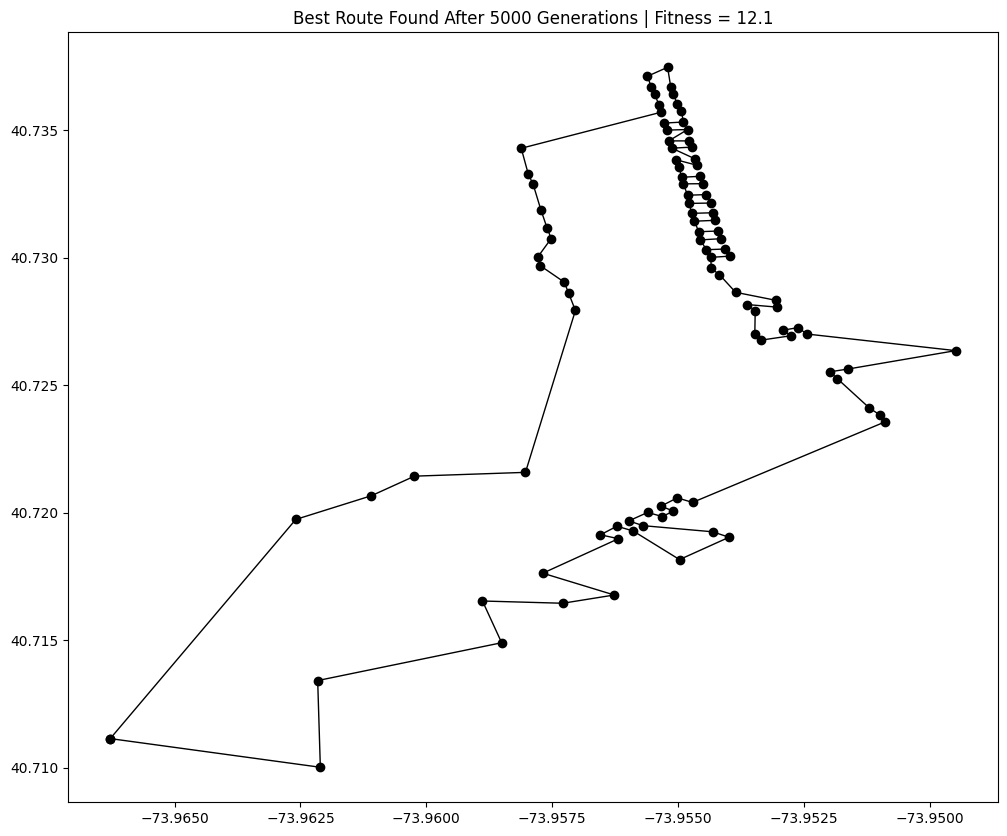

In [84]:
latitudes = []
longitudes = []
for bin in route:
    lat, lon = bin_info.get_coord(bin)
    latitudes.append(lat)
    longitudes.append(lon)
    
latitudes.append(latitudes[0])
longitudes.append(longitudes[0])

plt_route, ax = plt.subplots()
ax.plot(longitudes, latitudes, '-go', linewidth=1, color='black')        
plt.title(label=("Best Route Found After " +  str(gen_count) +  " Generations | Fitness = " + str(round(evaluation.fitness(route, bin_info), 2))))

plt_route.set_size_inches(12, 10)    
plt.savefig('solution' + str(gen_count) + '.png')
plt.show()

#### SHAP Results

In [85]:
import shap

"""
bin_data = pd.DataFrame(bin_info.bins, columns=bin_info.headers)
print(bin_info.headers)
X = np.asarray(bin_info.bins)
X = X[:,-2:]
explainer = shap.PermutationExplainer(route,X)
shap_vals = explainer(X[:100])
shap.summary_plot(shap_values=shap_vals, features=route, plot_type='bar')
"""

"\nbin_data = pd.DataFrame(bin_info.bins, columns=bin_info.headers)\nprint(bin_info.headers)\nX = np.asarray(bin_info.bins)\nX = X[:,-2:]\nexplainer = shap.PermutationExplainer(route,X)\nshap_vals = explainer(X[:100])\nshap.summary_plot(shap_values=shap_vals, features=route, plot_type='bar')\n"

#### DiCE Results

In [86]:
"""
import dice_ml
from dice_ml.utils import helpers
import copy

# DiCE Test
import sklearn.linear_model as lm
from sklearn.model_selection import train_test_split

dataset = helpers.load_adult_income_dataset()

target = dataset["income"]
train, test, _, _ = train_test_split(dataset, target, test_size=0.2, random_state=0, stratify=target)

print(train)

d = dice_ml.Data(dataframe=train, continuous_features=['age', 'hours_per_week'], outcome_name='income')
m = dice_ml.Model(model_path=helpers.get_adult_income_modelpath(), backend='TF2', func='ohe-min-max')
exp = dice_ml.Dice(d,m)

query_instance = test.drop(columns="income")[0:1]

dice_exp = exp.generate_counterfactuals(query_instance, 4, "opposite")
dice_exp.visualize_as_dataframe()


dataset = copy.deepcopy(bin_info.bins)
for row in range(len(dataset)):
    dataset[row].append(route.index(row))
cols = copy.deepcopy(bin_info.headers)
cols.append("route_pos")
bin_data = pd.DataFrame(dataset, columns=cols)

target = bin_data["route_pos"]
train, test, _, _ = train_test_split(bin_data, target, test_size=0.2, random_state=0)


d = dice_ml.Data(dataframe=train, continuous_features=['point_latitude', 'point_longitude'], outcome_name='route_pos')
m = dice_ml.Model(model=BinsEA, backend='TF2', func='ohe-min-max')
exp = dice_ml.Dice(d,m)

query_instance = test.drop(columns="route_pos")[0:1]

dice_exp = exp.generate_counterfactuals(query_instance, 4, "opposite")
dice_exp.visualize_as_dataframe()"""

'\nimport dice_ml\nfrom dice_ml.utils import helpers\nimport copy\n\n# DiCE Test\nimport sklearn.linear_model as lm\nfrom sklearn.model_selection import train_test_split\n\ndataset = helpers.load_adult_income_dataset()\n\ntarget = dataset["income"]\ntrain, test, _, _ = train_test_split(dataset, target, test_size=0.2, random_state=0, stratify=target)\n\nprint(train)\n\nd = dice_ml.Data(dataframe=train, continuous_features=[\'age\', \'hours_per_week\'], outcome_name=\'income\')\nm = dice_ml.Model(model_path=helpers.get_adult_income_modelpath(), backend=\'TF2\', func=\'ohe-min-max\')\nexp = dice_ml.Dice(d,m)\n\nquery_instance = test.drop(columns="income")[0:1]\n\ndice_exp = exp.generate_counterfactuals(query_instance, 4, "opposite")\ndice_exp.visualize_as_dataframe()\n\n\ndataset = copy.deepcopy(bin_info.bins)\nfor row in range(len(dataset)):\n    dataset[row].append(route.index(row))\ncols = copy.deepcopy(bin_info.headers)\ncols.append("route_pos")\nbin_data = pd.DataFrame(dataset, colum

#### ALE Results

In [87]:
from alibi.explainers import ALE
ale = ALE()
exp = ALE.explain(X=bin_data)

TypeError: ALE.__init__() missing 1 required positional argument: 'predictor'